In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from glob import glob
from IPython.display import clear_output
from matplotlib import ticker
from scipy.stats import gmean
from sklearn.metrics import confusion_matrix
from src.data.synthetic_gen import DataLoader
from src.models.classification import NeuralNetClassifier
from src.models.classification.evaluate_models import ClassificationAnalysis
from src.models.classification.train_models import ClassificationTraining
from src.visualization.styles.formatting import errorbar_kwargs

tf.random.set_seed(13)

In [2]:
classifier_model_name = "Rede Neural #8"
generator_model_name = "WGAN #11"

training = ClassificationTraining()
analysis = ClassificationAnalysis()

results = training.load_training_models()
indices = analysis.load_performance_indices()

output = [out for out in results["outputs"] if out["model_name"] == classifier_model_name][0]
model_id = [i for i, out in enumerate(results["outputs"]) if out["model_name"] == classifier_model_name][0]

print(f"Modelo: {output['model_name']}, ID: {model_id}")
print("    params:", output["params"])
print("    opt:   ", output["opt"])


Modelo: Rede Neural #8, ID: 23
    params: {'hidden_units': [64, 64], 'activation': 'relu'}
    opt:    {'lr': 0.001, 'epochs': 500, 'batch_size': 32}


### Training best neural network

In [3]:
# Train best neural network
# Rede Neural #8
learning_rate = output["opt"]["lr"]
epochs = output["opt"]["epochs"]
batch_size = output["opt"]["batch_size"]

params = {"hidden_units": output["params"]["hidden_units"], "activation": output["params"]["activation"]}

dataset_sizes = [1, 2, 3, 5, 10]

for dataset_size in dataset_sizes:
    dl = DataLoader(problem="classification", model_name=generator_model_name, dataset_size=dataset_size)
    datasets, minmax = dl.load_cross_validation_datasets()

    train_data = datasets["train"]
    valid_data = datasets["valid"]

    models = []
    for i, (train, valid) in enumerate(zip(train_data, valid_data)):

        train_features, train_labels = train["features"], train["targets"]
        valid_features, valid_labels = valid["features"], valid["targets"]

        features, labels = train_features.values, train_labels.values
        train_ds = tf.data.Dataset.from_tensor_slices((features, labels)).shuffle(10000).batch(batch_size)

        features, labels = valid_features.values, valid_labels.values
        valid_ds = tf.data.Dataset.from_tensor_slices((features, labels)).batch(batch_size)

        loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        accuracy = tf.keras.metrics.CategoricalAccuracy()
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        callbacks = [
            tf.keras.callbacks.ReduceLROnPlateau(),
            # patience 10% of epochs size
            tf.keras.callbacks.EarlyStopping(min_delta=0.0001, patience=50),
        ]
        model = NeuralNetClassifier(**params)
        model.compile(optimizer=optimizer, loss=loss_object, metrics=[accuracy])
        h = model.fit(
            train_ds,
            epochs=epochs,
            validation_data=valid_ds,
            callbacks=callbacks,
            verbose=1,  # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch
        )

        models.append(model)

        models_folder = os.path.join(
            "data",
            "models",
            "classification_with_synthetic_dataset",
            generator_model_name,
            f"{dataset_size}to1",
        )
        if not os.path.isdir(models_folder):
            os.makedirs(models_folder)

        model.save(os.path.join(models_folder, f"model_fold={i+1}.keras"))
        clear_output(wait=True)

Epoch 1/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_accuracy: 0.5449 - loss: 1.0057 - val_categorical_accuracy: 0.6182 - val_loss: 0.7969 - learning_rate: 0.0010
Epoch 2/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - categorical_accuracy: 0.6311 - loss: 0.7669 - val_categorical_accuracy: 0.7273 - val_loss: 0.6722 - learning_rate: 0.0010
Epoch 3/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - categorical_accuracy: 0.6949 - loss: 0.6441 - val_categorical_accuracy: 0.7273 - val_loss: 0.6288 - learning_rate: 0.0010
Epoch 4/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - categorical_accuracy: 0.6813 - loss: 0.6090 - val_categorical_accuracy: 0.7818 - val_loss: 0.5740 - learning_rate: 0.0010
Epoch 5/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - categorical_accuracy: 0.7112 - loss: 0.5667 - val_categorical_accuracy: 0.7818 - val_loss: 0.5520 - learning_rate: 0.0010
Epoch 6/500
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - categorical_accuracy: 0.7375 - loss: 0.5391 - val_

### Evaluation

In [4]:
# Load saved models trained with synthetic dataset
def calculate_performances_values(folder, dataset_size, generator_model):
    dl = DataLoader(problem="classification", model_name=generator_model, dataset_size=dataset_size)
    datasets, _ = dl.load_cross_validation_datasets()

    valid_data = datasets["valid"]

    models = [tf.keras.models.load_model(model_file) for model_file in glob(os.path.join(folder, "*.keras"))]

    confusion_matrix_values = []
    accuracies = []
    sensitivities = []
    sp_indexes = []

    for valid, model in zip(valid_data, models):
        valid_features, valid_labels = valid["features"], valid["targets"]

        X_valid = tf.convert_to_tensor(valid_features)
        probs = tf.convert_to_tensor(valid_labels)
        y_valid = tf.argmax(probs, axis=1)

        logits = model(X_valid)
        probs_hat = tf.nn.softmax(logits)
        y_valid_hat = tf.argmax(probs_hat, axis=1)

        # Confusion matrix
        cm = confusion_matrix(y_valid, y_valid_hat)
        confusion_matrix_values.append(cm)

        # Accuracy
        accuracies.append(np.diag(cm).sum() / cm.sum())

        # Sensitivity
        sens = np.diag(cm) / cm.sum(axis=1)
        sensitivities.append(sens)

        # SP Index
        sp_indexes.append(np.sqrt(np.mean(sens) * gmean(sens)))

    confusion_matrix_values = np.array(confusion_matrix_values)
    accuracies = np.array(accuracies)
    sensitivities = np.array(sensitivities)
    sp_indexes = np.array(sp_indexes)

    print(f"Dataset {dataset_size}to1")
    print(f"Accuracy = {(100 * accuracies).mean():.2f} +/- {(100 * accuracies).std() / np.sqrt(5 - 1):.2f} %")

    mean_sens = (100 * sensitivities).mean(axis=0)
    std_err_sens = (100 * sensitivities).std(axis=0) / np.sqrt(5 - 1)
    print(f"Sensitivity [V] = {mean_sens[0]:.2f} +/- {std_err_sens[0]:.2f} %")
    print(f"Sensitivity [VL] = {mean_sens[1]:.2f} +/- {std_err_sens[1]:.2f} %")
    print(f"Sensitivity [L] = {mean_sens[2]:.2f} +/- {std_err_sens[2]:.2f} %")

    print(f"SP Index = {(100 * sp_indexes).mean():.2f} +/- {(100 * sp_indexes).std() / np.sqrt(5 - 1):.2f} %")
    print()

    return {
        "confusion_matrix": confusion_matrix_values,
        "accuracies": accuracies,
        "sensitivities": sensitivities,
        "sp_indexes": sp_indexes,
    }

In [8]:
model_name = "WGAN #11"

models_folder = glob(
    os.path.join(
        "data",
        "models",
        "classification_with_synthetic_dataset",
        model_name,
        "*",
    )
)
models_folder = sorted(models_folder, key=lambda p: int(os.path.split(p)[-1].split("to")[0]))

print(f"Classificador: {classifier_model_name}, Gerador: {model_name}")
wgan_indices_dict = {}
for folder in models_folder:
    dataset_size = int(os.path.split(folder)[-1].split("to")[0])
    wgan_indices_dict[f"Sintético {dataset_size}x"] = calculate_performances_values(folder, dataset_size, model_name)

Classificador: Rede Neural #8, Gerador: WGAN #11
Dataset 1to1
Accuracy = 82.27 +/- 3.98 %
Sensitivity [V] = 88.89 +/- 1.96 %
Sensitivity [VL] = 72.37 +/- 9.19 %
Sensitivity [L] = 86.11 +/- 3.11 %
SP Index = 81.96 +/- 4.23 %

Dataset 2to1
Accuracy = 86.36 +/- 1.98 %
Sensitivity [V] = 88.89 +/- 1.96 %
Sensitivity [VL] = 81.58 +/- 2.94 %
Sensitivity [L] = 88.89 +/- 4.39 %
SP Index = 86.34 +/- 1.99 %

Dataset 3to1
Accuracy = 89.55 +/- 2.17 %
Sensitivity [V] = 87.50 +/- 1.20 %
Sensitivity [VL] = 88.16 +/- 4.70 %
Sensitivity [L] = 93.06 +/- 1.20 %
SP Index = 89.51 +/- 2.13 %

Dataset 5to1
Accuracy = 91.36 +/- 1.62 %
Sensitivity [V] = 93.06 +/- 1.20 %
Sensitivity [VL] = 88.16 +/- 5.99 %
Sensitivity [L] = 93.06 +/- 2.30 %
SP Index = 91.26 +/- 1.65 %

Dataset 10to1
Accuracy = 95.00 +/- 0.99 %
Sensitivity [V] = 94.44 +/- 1.96 %
Sensitivity [VL] = 94.74 +/- 2.63 %
Sensitivity [L] = 95.83 +/- 1.20 %
SP Index = 94.97 +/- 0.98 %



In [6]:
model_name = "Dirichlet Estimator"

models_folder = glob(
    os.path.join(
        "data",
        "models",
        "classification_with_synthetic_dataset",
        model_name,
        "*",
    )
)
models_folder = sorted(models_folder, key=lambda p: int(os.path.split(p)[-1].split("to")[0]))

print(f"Classificador: {classifier_model_name}, Gerador: {model_name}")
dirichlet_indices_dict = {}
for folder in models_folder:
    dataset_size = int(os.path.split(folder)[-1].split("to")[0])
    dirichlet_indices_dict[f"Sintético {dataset_size}x"] = calculate_performances_values(
        folder,
        dataset_size,
        model_name,
    )

Classificador: Rede Neural #8, Gerador: Dirichlet Estimator
Dataset 1to1
Accuracy = 73.64 +/- 3.31 %
Sensitivity [V] = 76.39 +/- 6.01 %
Sensitivity [VL] = 57.89 +/- 4.92 %
Sensitivity [L] = 87.50 +/- 4.55 %
SP Index = 73.17 +/- 3.47 %

Dataset 2to1
Accuracy = 78.18 +/- 3.21 %
Sensitivity [V] = 77.78 +/- 3.93 %
Sensitivity [VL] = 73.68 +/- 6.45 %
Sensitivity [L] = 83.33 +/- 4.39 %
SP Index = 78.02 +/- 3.20 %

Dataset 3to1
Accuracy = 81.82 +/- 2.32 %
Sensitivity [V] = 77.78 +/- 1.96 %
Sensitivity [VL] = 80.26 +/- 2.87 %
Sensitivity [L] = 87.50 +/- 3.03 %
SP Index = 81.77 +/- 2.31 %

Dataset 5to1
Accuracy = 79.55 +/- 1.62 %
Sensitivity [V] = 73.61 +/- 2.30 %
Sensitivity [VL] = 76.32 +/- 5.74 %
Sensitivity [L] = 88.89 +/- 3.40 %
SP Index = 79.28 +/- 1.65 %

Dataset 10to1
Accuracy = 88.18 +/- 1.36 %
Sensitivity [V] = 80.56 +/- 4.17 %
Sensitivity [VL] = 89.47 +/- 1.86 %
Sensitivity [L] = 94.44 +/- 2.78 %
SP Index = 87.96 +/- 1.41 %



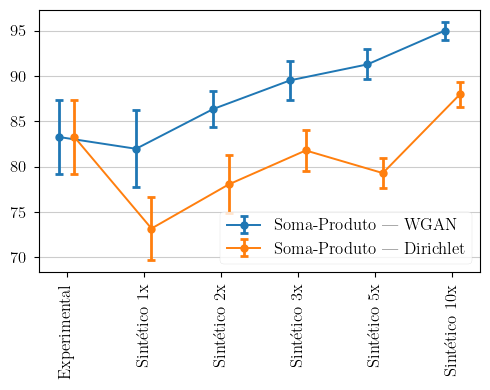

In [ ]:
name = classifier_model_name.replace("#", "\#")

labels = [f"Experimental", *wgan_indices_dict.keys()]

x = np.arange(len(labels))
wgan_x = x - 0.1
dirichet_x = x + 0.1

f, ax = plt.subplots(figsize=(5, 4))

wgan_sp_idx = np.r_[[indices["sp_index"][:, model_id]], np.array([i["sp_indexes"] for i in wgan_indices_dict.values()])]
dirichlet_sp_idx = np.r_[
    [indices["sp_index"][:, model_id]], np.array([i["sp_indexes"] for i in dirichlet_indices_dict.values()])
]

wgan_y = wgan_sp_idx.mean(axis=1) * 100
wgan_y_err = (wgan_sp_idx.std(axis=1) / np.sqrt(5 - 1)) * 100

dirichlet_y = dirichlet_sp_idx.mean(axis=1) * 100
dirichlet_y_err = (dirichlet_sp_idx.std(axis=1) / np.sqrt(5 - 1)) * 100

ax.errorbar(wgan_x, wgan_y, wgan_y_err, label="Soma-Produto (WGAN)", c="tab:blue", **errorbar_kwargs)
ax.errorbar(dirichet_x, dirichlet_y, dirichlet_y_err, label="Soma-Produto (Dirichlet)", c="tab:orange", **errorbar_kwargs)
ax.yaxis.grid()
ax.set_xticks(x, labels, rotation=90, ha="center")
ax.legend(loc="lower right")

f.tight_layout()
plt.savefig(os.path.join("data", "images", "sp_index_errorbar_plot_synthetic.png"), dpi=600)
plt.show()

In [ ]:
def plot_confusion_matrix(cm, ax, model_name):
    cm = cm / np.sum(cm, axis=2)[:, :, None]
    cm_mean = np.mean(cm, axis=0)
    cm_std = np.std(cm, axis=0) / np.sqrt(10 - 1)

    ms = ax.matshow(cm_mean, alpha=0.5, cmap="Greys")
    for ii in range(cm_mean.shape[0]):
        for jj in range(cm_mean.shape[1]):
            text = f"{cm_mean[ii, jj] * 100:1.2f} \\textpm \n {cm_std[ii, jj] * 100:1.2f} \%"
            ax.text(x=jj, y=ii, s=text, va="center", ha="center", size="x-large")

    cbar = ax.figure.colorbar(ms, ax=ax, shrink=0.675, format=ticker.PercentFormatter(xmax=1))
    ax.set_xlabel("Classes Estimadas")
    # ax.set_ylabel("Classes Reais")
    ax.set_title(model_name.replace("#", "\#"))

    # 0: gas, 1: mix, 2: oil
    ax.set_xticks([0, 1, 2], ["Vapor", "Mistura", "Líquido"])
    ax.set_yticks([0, 1, 2], ["Vapor", "Mistura", "Líquido"])
    ax.grid(False)

f, axs = plt.subplots(1, 3, figsize=(15, 5))

cm_real = indices["confusion_matrix"][:, model_id, :, :].astype("int16")
cm_synthetic_1to1 = indices_dict["Sintético 1x"]["confusion_matrix"].astype("int16")
cm_synthetic_10to1 = indices_dict["Sintético 10x"]["confusion_matrix"].astype("int16")
plot_confusion_matrix(cm_real, axs[0], f"{classifier_model_name} (Experimental)")
plot_confusion_matrix(cm_synthetic_1to1, axs[1], f"{classifier_model_name} (Sintético 1x)")
plot_confusion_matrix(cm_synthetic_10to1, axs[2], f"{classifier_model_name} (Sintético 10x)")

f.supylabel("Classes Reais")
f.tight_layout()

plt.savefig(os.path.join("data", "images", "comparing_confusion_matrices_synthetic.png"), dpi=600)
plt.show()